In [1]:
import os
import uproot
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import random
import awkward as ak # Using awkward array for easier handling of jagged data
import time # For timing steps

# Set seeds for reproducibility
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
os.environ['PYTHONHASHSEED'] = str(seed_value)

def load_root_file(file_path, branches=None, print_branches=False):
    all_branches = {}
    with uproot.open(file_path) as file:
        tree = file["tree"]
        # Load all ROOT branches into array if not specified
        if branches is None:
            branches = tree.keys()
        # Option to print the branch names
        if print_branches:
            print("Branches:", tree.keys())
        # Each branch is added to the dictionary
        for branch in branches:
            try:
                all_branches[branch] = (tree[branch].array(library="np"))
            except uproot.KeyInFileError as e:
                print(f"KeyInFileError: {e}")
        # Number of events in file
        all_branches['event'] = tree.num_entries
    return all_branches

branches_list = [
    't5_innerRadius',
    't5_bridgeRadius',
    't5_outerRadius',
    't5_pt',
    't5_eta',
    't5_phi',
    't5_isFake',
    't5_t3_idx0',
    't5_t3_idx1',

    't5_t3_fakeScore1',
    't5_t3_promptScore1',
    't5_t3_displacedScore1',
    't5_t3_fakeScore2',
    't5_t3_promptScore2',
    't5_t3_displacedScore2',

    't5_pMatched',
    't5_sim_vxy',
    't5_sim_vz',
    't5_matched_simIdx'
]

branches_list += [
    'pLS_eta',
    'pLS_etaErr',
    'pLS_phi',
    'pLS_matched_simIdx',
    'pLS_circleCenterX',
    'pLS_circleCenterY',
    'pLS_circleRadius',
    'pLS_ptIn',
    'pLS_ptErr',
    'pLS_px',
    'pLS_py',
    'pLS_pz',
    'pLS_isQuad',
    'pLS_isFake'
]

# Hit-dependent branches
suffixes = ['r', 'z', 'eta', 'phi', 'layer']
branches_list += [f't5_t3_{i}_{suffix}' for i in [0, 2, 4] for suffix in suffixes]

file_path = "pls_t5_embed.root"
branches = load_root_file(file_path, branches_list, print_branches=True)

Branches: ['sim_pt', 'sim_eta', 'sim_phi', 'sim_pca_dxy', 'sim_pca_dz', 'sim_q', 'sim_event', 'sim_pdgId', 'sim_vx', 'sim_vy', 'sim_vz', 'sim_trkNtupIdx', 'sim_TC_matched', 'sim_TC_matched_mask', 'tc_pt', 'tc_eta', 'tc_phi', 'tc_type', 'tc_isFake', 'tc_isDuplicate', 'tc_matched_simIdx', 'sim_dummy', 'tc_dummy', 'pT5_matched_simIdx', 'pT5_hitIdxs', 'sim_pT5_matched', 'pT5_pt', 'pT5_eta', 'pT5_phi', 'pT5_isFake', 't5_sim_vxy', 't5_sim_vz', 'pT5_isDuplicate', 'pT5_score', 'pT5_layer_binary', 'pT5_moduleType_binary', 'pT5_matched_pt', 'pT5_rzChiSquared', 'pT5_rPhiChiSquared', 'pT5_rPhiChiSquaredInwards', 'sim_pT3_matched', 'pT3_pt', 'pT3_isFake', 'pT3_isDuplicate', 'pT3_eta', 'pT3_phi', 'pT3_score', 'pT3_foundDuplicate', 'pT3_matched_simIdx', 'pT3_hitIdxs', 'pT3_pixelRadius', 'pT3_pixelRadiusError', 'pT3_matched_pt', 'pT3_tripletRadius', 'pT3_rPhiChiSquared', 'pT3_rPhiChiSquaredInwards', 'pT3_rzChiSquared', 'pT3_layer_binary', 'pT3_moduleType_binary', 'sim_pLS_matched', 'pLS_matched_simIdx

In [2]:
z_max = np.max([np.max(event) for event in branches[f't5_t3_4_z']])
r_max = np.max([np.max(event) for event in branches[f't5_t3_4_r']])
eta_max = 2.5
phi_max = np.pi
n_events = np.shape(branches['t5_pt'])[0]

print(f'Z max: {z_max}, R max: {r_max}, Eta max: {eta_max}')

def delta_phi(phi1, phi2):
    delta = phi1 - phi2
    # Adjust delta to be within the range [-pi, pi]
    if delta > np.pi:
        delta -= 2 * np.pi
    elif delta < -np.pi:
        delta += 2 * np.pi
    return delta

Z max: 267.2349853515625, R max: 110.10993957519531, Eta max: 2.5


In [3]:
pMATCHED_THRESHOLD = 0.        # keep if t5_pMatched ≥ this
print(f"\nBuilding T5 features  (pMatched ≥ {pMATCHED_THRESHOLD}) …")

features_per_event    = []
eta_per_event         = []
displaced_per_event = []
sim_indices_per_event = []

kept_tot, init_tot = 0, 0
for ev in range(n_events):

    n_t5 = len(branches['t5_t3_idx0'][ev])
    init_tot += n_t5
    if n_t5 == 0:
        continue

    feat_evt = []
    eta_evt  = []
    sim_evt  = []
    disp_evt = []

    for i in range(n_t5):
        if branches['t5_pMatched'][ev][i] < pMATCHED_THRESHOLD:
            continue

        idx0 = branches['t5_t3_idx0'][ev][i]
        idx1 = branches['t5_t3_idx1'][ev][i]

        # hit-level quantities -------------------------------------------------
        eta1 = (branches['t5_t3_0_eta'][ev][idx0])
        eta2 = abs(branches['t5_t3_2_eta'][ev][idx0])
        eta3 = abs(branches['t5_t3_4_eta'][ev][idx0])
        eta4 = abs(branches['t5_t3_2_eta'][ev][idx1])
        eta5 = abs(branches['t5_t3_4_eta'][ev][idx1])

        phi1 = branches['t5_t3_0_phi'][ev][idx0]
        phi2 = branches['t5_t3_2_phi'][ev][idx0]
        phi3 = branches['t5_t3_4_phi'][ev][idx0]
        phi4 = branches['t5_t3_2_phi'][ev][idx1]
        phi5 = branches['t5_t3_4_phi'][ev][idx1]

        z1 = abs(branches['t5_t3_0_z'][ev][idx0])
        z2 = abs(branches['t5_t3_2_z'][ev][idx0])
        z3 = abs(branches['t5_t3_4_z'][ev][idx0])
        z4 = abs(branches['t5_t3_2_z'][ev][idx1])
        z5 = abs(branches['t5_t3_4_z'][ev][idx1])

        r1 = branches['t5_t3_0_r'][ev][idx0]
        r2 = branches['t5_t3_2_r'][ev][idx0]
        r3 = branches['t5_t3_4_r'][ev][idx0]
        r4 = branches['t5_t3_2_r'][ev][idx1]
        r5 = branches['t5_t3_4_r'][ev][idx1]

        inR  = branches['t5_innerRadius' ][ev][i]
        brR  = branches['t5_bridgeRadius'][ev][i]
        outR = branches['t5_outerRadius' ][ev][i]

        s1_fake   = branches['t5_t3_fakeScore1'     ][ev][i]
        s1_prompt = branches['t5_t3_promptScore1'   ][ev][i]
        s1_disp   = branches['t5_t3_displacedScore1'][ev][i]
        d_fake    = branches['t5_t3_fakeScore2'     ][ev][i] - s1_fake
        d_prompt  = branches['t5_t3_promptScore2'   ][ev][i] - s1_prompt
        d_disp    = branches['t5_t3_displacedScore2'][ev][i] - s1_disp

        f = [
            eta1 / eta_max,
            0.0, # np.cos(phi1),
            0.0, # np.sin(phi1),
            z1 / z_max,
            r1 / r_max,

            eta2 - abs(eta1),
            delta_phi(phi2, phi1),
            (z2 - z1) / z_max,
            (r2 - r1) / r_max,

            eta3 - eta2,
            delta_phi(phi3, phi2),
            (z3 - z2) / z_max,
            (r3 - r2) / r_max,

            eta4 - eta3,
            delta_phi(phi4, phi3),
            (z4 - z3) / z_max,
            (r4 - r3) / r_max,

            eta5 - eta4,
            delta_phi(phi5, phi4),
            (z5 - z4) / z_max,
            (r5 - r4) / r_max,

            1.0 / inR,
            1.0 / brR,
            1.0 / outR,

            s1_fake, s1_prompt, s1_disp,
            d_fake,  d_prompt,  d_disp
        ]
        feat_evt.append(f)
        eta_evt.append(eta1)
        disp_evt.append(branches['t5_sim_vxy'][ev][i])

        # first (or only) matched sim-index, -1 if none -----------------------
        simIdx_list = branches['t5_matched_simIdx'][ev][i]
        sim_evt.append(simIdx_list[0] if len(simIdx_list) else -1)

    # push to global containers ----------------------------------------------
    if feat_evt:                                # skip events with no survivors
        features_per_event.append(np.asarray(feat_evt, dtype=np.float32))
        eta_per_event.append(np.asarray(eta_evt,  dtype=np.float32))
        displaced_per_event.append(np.asarray(disp_evt, dtype=np.float32))
        sim_indices_per_event.append(np.asarray(sim_evt, dtype=np.int64))
        kept_tot += len(feat_evt)

print(f"\nKept {kept_tot} / {init_tot} T5s "
      f"({kept_tot/init_tot*100:.2f} %) that passed the pMatched cut.")
print(f"Total events with ≥1 kept T5: {len(features_per_event)}")


Building T5 features  (pMatched ≥ 0.0) …

Kept 3630781 / 3630781 T5s (100.00 %) that passed the pMatched cut.
Total events with ≥1 kept T5: 500


In [4]:
KEEP_FRAC_PLS = 0.40
print(f"\nBuilding pLS features …")

pLS_features_per_event    = []
pLS_eta_per_event         = []
pLS_sim_indices_per_event = []

kept_tot_pls, init_tot_pls = 0, 0
for ev in range(n_events):
    n_pls = len(branches['pLS_eta'][ev])
    init_tot_pls += n_pls
    if n_pls == 0:
        continue

    feat_evt, eta_evt, sim_evt = [], [], []

    for i in range(n_pls):
        if branches['pLS_isFake'][ev][i]:
            continue
        if np.random.random() > KEEP_FRAC_PLS:
            continue

        # ――― hit‑level quantities -------------------------------------------
        eta = branches['pLS_eta'][ev][i]
        etaErr = branches['pLS_etaErr'][ev][i]
        phi = branches['pLS_phi'][ev][i]
        circleCenterX = np.abs(branches['pLS_circleCenterX'][ev][i])
        circleCenterY = np.abs(branches['pLS_circleCenterY'][ev][i])
        circleRadius = branches['pLS_circleRadius'][ev][i]
        ptIn = branches['pLS_ptIn'][ev][i]
        ptErr = branches['pLS_ptErr'][ev][i]
        isQuad = branches['pLS_isQuad'][ev][i]

        # ――― build feature vector -------------------------------------------
        f = [
            eta/4.0,
            etaErr/.00139,
            0.0, # np.cos(phi),
            0.0, # np.sin(phi),
            1.0 / ptIn,
            np.log10(ptErr),
            isQuad,
            np.log10(circleCenterX),
            np.log10(circleCenterY),
            np.log10(circleRadius),
        ]

        feat_evt.append(f)
        eta_evt.append(eta)

        sim_list = branches['pLS_matched_simIdx'][ev][i]
        sim_evt.append(sim_list[0] if len(sim_list) else -1)

    # ――― store per‑event containers -----------------------------------------
    if feat_evt:              # skip events with no survivors
        pLS_features_per_event   .append(np.asarray(feat_evt, dtype=np.float32))
        pLS_eta_per_event        .append(np.asarray(eta_evt,  dtype=np.float32))
        pLS_sim_indices_per_event.append(np.asarray(sim_evt, dtype=np.int64))
        kept_tot_pls += len(feat_evt)

print(f"\nKept {kept_tot_pls} / {init_tot_pls} pLSs "
      f"({kept_tot_pls/init_tot_pls*100:.2f} %) that passed the selections.")
print(f"Total events with ≥1 kept pLS: {len(pLS_features_per_event)}")


Building pLS features …

Kept 3722110 / 11314631 pLSs (32.90 %) that passed the selections.
Total events with ≥1 kept pLS: 500


In [5]:
import time, random, math, numpy as np
from concurrent.futures import ProcessPoolExecutor, as_completed
from sklearn.model_selection import train_test_split

DELTA_R2_CUT = 0.02

# ---------------------------------------------------------------------------
def _delta_phi(phi1, phi2):
    """same helper you already defined, but inline for the worker"""
    d = phi1 - phi2
    if d > math.pi:
        d -= 2 * math.pi
    elif d < -math.pi:
        d += 2 * math.pi
    return d
# ---------------------------------------------------------------------------
def _pairs_single_event(evt_idx,
                        F, S, D,
                        max_sim, max_dis,
                        invalid_sim):
    """
    Worker run in a separate process.
    Returns two Python lists with the selected (i,j) indices per event.
    """
    n = F.shape[0]
    if n < 2:
        return evt_idx, [], []

    eta1 = F[:, 0] * eta_max
    phi1 = np.arctan2(F[:, 2], F[:, 1])

    # upper-triangle (non-diagonal) indices
    idx_l, idx_r = np.triu_indices(n, k=1)
    idxs_triu = np.stack((idx_l, idx_r), axis=-1)

    # sim indices for each pair
    simidx_l = S[idx_l]
    simidx_r = S[idx_r]

    # calculate DR2
    eta_l = eta1[idx_l]
    eta_r = eta1[idx_r]
    phi_l = phi1[idx_l]
    phi_r = phi1[idx_r]
    dphi = np.abs(phi_l - phi_r)
    dphi[dphi > np.pi] -= 2 * np.pi # adjust to [-pi, pi]
    dr2 = (eta_l - eta_r)**2 + dphi**2

    # make masks
    dr2_valid = (dr2 < DELTA_R2_CUT)
    sim_idx_same = (simidx_l == simidx_r)
    sim_mask = dr2_valid & sim_idx_same & (simidx_l != invalid_sim)
    dis_mask = dr2_valid & ~sim_idx_same

    # get pairs from masks
    sim_pairs = idxs_triu[sim_mask]
    dis_pairs = idxs_triu[dis_mask]

    # down-sample
    random.seed(evt_idx)
    if len(sim_pairs) > max_sim:
        sim_pairs = sim_pairs[random.sample(range(len(sim_pairs)), max_sim)]
    if len(dis_pairs) > max_dis:
        dis_pairs = dis_pairs[random.sample(range(len(dis_pairs)), max_dis)]

    print(f"[evt {evt_idx:4d}]  T5s={n:5d}  sim={len(sim_pairs):3d}  dis={len(dis_pairs):3d}")
    return evt_idx, sim_pairs, dis_pairs

# ---------------------------------------------------------------------------
def create_t5_pairs_balanced_parallel(features_per_event,
                                      sim_indices_per_event,
                                      displaced_per_event,
                                      *,
                                      max_similar_pairs_per_event=100,
                                      max_dissimilar_pairs_per_event=450,
                                      invalid_sim_idx=-1,
                                      n_workers=None):
    t0 = time.time()
    print("\n>>> Pair generation  (ΔR² < 0.02)  –  parallel mode")

    work_args = [
        (evt_idx,
         features_per_event[evt_idx],
         sim_indices_per_event[evt_idx],
         displaced_per_event[evt_idx],
         max_similar_pairs_per_event,
         max_dissimilar_pairs_per_event,
         invalid_sim_idx)
        for evt_idx in range(len(features_per_event))
    ]

    sim_L, sim_R, sim_disp = [], [], []
    dis_L, dis_R, dis_disp = [], [], []

    with ProcessPoolExecutor(max_workers=n_workers) as pool:
        futures = [pool.submit(_pairs_single_event, *args) for args in work_args]
        for fut in futures:
            evt_idx, sim_pairs_evt, dis_pairs_evt = fut.result()
            F = features_per_event[evt_idx]
            D = displaced_per_event[evt_idx]

            for i, j in sim_pairs_evt:
                sim_L.append(F[i])
                sim_R.append(F[j])
                sim_disp.append(D[i] > 0.1 or D[j] > 0.1)

            for i, j in dis_pairs_evt:
                dis_L.append(F[i])
                dis_R.append(F[j])
                dis_disp.append(D[i] > 0.1 or D[j] > 0.1)

    X_left  = np.concatenate([np.asarray(sim_L, dtype=np.float32),
                              np.asarray(dis_L, dtype=np.float32)], axis=0)
    X_right = np.concatenate([np.asarray(sim_R, dtype=np.float32),
                              np.asarray(dis_R, dtype=np.float32)], axis=0)
    y       = np.concatenate([np.zeros(len(sim_L), dtype=np.int32),
                              np.ones (len(dis_L), dtype=np.int32)])

    disp_L = np.concatenate([np.asarray(sim_disp, dtype=bool),
                             np.asarray(dis_disp, dtype=bool)], axis=0)
    disp_R = disp_L.copy()

    print(f"<<< done in {time.time() - t0:.1f}s  | sim {len(sim_L)}  dis {len(dis_L)}  total {len(y)}")
    return X_left, X_right, y, disp_L, disp_R

# invoke
X_left, X_right, y, disp_L, disp_R = create_t5_pairs_balanced_parallel(
    features_per_event,
    sim_indices_per_event,
    displaced_per_event,
    max_similar_pairs_per_event    = 1000,
    max_dissimilar_pairs_per_event = 1000,
    invalid_sim_idx                = -1,
    n_workers                      = None
)

if len(y) == 0:
    raise ValueError("No pairs generated. Check filters/data.")

mask = (np.isfinite(X_left).all(axis=1) &
        np.isfinite(X_right).all(axis=1))
if not mask.all():
    print(f"Filtering {np.sum(~mask)} pairs with NaN/Inf")
    X_left, X_right, y, disp_L, disp_R = X_left[mask], X_right[mask], y[mask], disp_L[mask], disp_R[mask]

weights_t5 = np.where(disp_L | disp_R, 5.0, 1.0).astype(np.float32)

X_left_train, X_left_test, \
X_right_train, X_right_test, \
y_t5_train, y_t5_test, \
w_t5_train, w_t5_test = train_test_split(
    X_left, X_right, y, weights_t5,
    test_size=0.20, random_state=42,
    stratify=y, shuffle=True
)

# compute displaced fraction
pct_disp = np.mean(disp_L | disp_R) * 100
print(f"{pct_disp:.2f}% of all pairs involve a displaced T5")


>>> Pair generation  (ΔR² < 0.02)  –  parallel mode
[evt    0]  T5s= 3864  sim=1000  dis=1000
[evt    1]  T5s= 4786  sim=1000  dis=1000
[evt    2]  T5s= 4648  sim=1000  dis=1000
[evt    6]  T5s= 6073  sim=1000  dis=1000
[evt    3]  T5s= 5868  sim=1000  dis=1000
[evt    5]  T5s= 5333  sim=1000  dis=1000
[evt    4]  T5s= 5981  sim=1000  dis=1000
[evt   16]  T5s= 6349  sim=1000  dis=1000
[evt    8]  T5s= 6067  sim=1000  dis=1000
[evt   15]  T5s= 7083  sim=1000  dis=1000
[evt   11]  T5s= 6286  sim=1000  dis=1000
[evt    9]  T5s= 6574  sim=1000  dis=1000
[evt   14]  T5s= 6820  sim=1000  dis=1000
[evt   22]  T5s= 6762  sim=1000  dis=1000
[evt   17]  T5s= 6682  sim=1000  dis=1000
[evt   12]  T5s= 6582  sim=1000  dis=1000
[evt   10]  T5s= 6834  sim=1000  dis=1000
[evt   33]  T5s= 4853  sim=1000  dis=1000
[evt   13]  T5s= 7061  sim=1000  dis=1000
[evt   18]  T5s= 6606  sim=1000  dis=1000
[evt   24]  T5s= 7620  sim=1000  dis=1000
[evt   35]  T5s= 6820  sim=1000  dis=1000
[evt    7]  T5s= 6334  

In [6]:
import numpy as np
import random
from concurrent.futures import ProcessPoolExecutor, as_completed
import time

# pairing hyper-parameters
DELTA_R2_CUT_PLS_T5 = 0.02
DISP_VXY_CUT       = 0.1
INVALID_SIM_IDX    = -1
MAX_SIM            = 1000
MAX_DIS            = 1000

def _pairs_pLS_T5_single(evt_idx,
                         F_pLS, S_pLS,
                         F_T5,  S_T5, D_T5,
                         max_sim, max_dis,
                         invalid_sim):
    """
    Build similar / dissimilar pLS-T5 pairs for a single event,
    printing per-event summary.
    """
    n_p, n_t = F_pLS.shape[0], F_T5.shape[0]
    sim_pairs, dis_pairs = [], []

    # if either collection is empty, report zeros and bail
    if n_p == 0 or n_t == 0:
        print(f"[evt {evt_idx:4d}]  pLSs={n_p:5d}  T5s={n_t:5d}  sim={0:4d}  dis={0:4d}")
        return evt_idx, []

    # un-normalize eta and compute phi angles
    eta_p = F_pLS[:,0] * 4.0
    phi_p = np.arctan2(F_pLS[:,3], F_pLS[:,2])
    eta_t = F_T5[:,0] * eta_max
    phi_t = np.arctan2(F_T5[:,2], F_T5[:,1])

    # make all possible pairs (i, j)
    idx_p, idx_t = np.indices( (n_p, n_t) )
    idx_p, idx_t = idx_p.flatten(), idx_t.flatten()

    # calculate angles
    dphi = (phi_p[idx_p] - phi_t[idx_t] + np.pi) % (2 * np.pi) - np.pi
    dr2 = (eta_p[idx_p] - eta_t[idx_t])**2 + dphi**2
    dr2_valid = (dr2 < DELTA_R2_CUT_PLS_T5)

    # compare sim indices
    simidx_p = S_pLS[idx_p]
    simidx_t = S_T5[idx_t]
    sim_idx_same = (simidx_p == simidx_t)

    # create masks for similar and dissimilar pairs
    sim_mask = dr2_valid & sim_idx_same & (simidx_p != invalid_sim)
    dis_mask = dr2_valid & ~sim_idx_same

    # get the pairs
    sim_pairs = np.column_stack((idx_p[sim_mask], idx_t[sim_mask]))
    dis_pairs = np.column_stack((idx_p[dis_mask], idx_t[dis_mask]))

    # down-sample
    random.seed(evt_idx)
    if len(sim_pairs) > max_sim:
        sim_pairs = sim_pairs[random.sample(range(len(sim_pairs)), max_sim)]
    if len(dis_pairs) > max_dis:
        dis_pairs = dis_pairs[random.sample(range(len(dis_pairs)), max_dis)]

    # print per-event summary
    print(f"[evt {evt_idx:4d}]  pLSs={n_p:5d}  T5s={n_t:5d}  "
          f"sim={len(sim_pairs):4d}  dis={len(dis_pairs):4d}")

    # pack into (feature, feature, label, displaced_flag)
    packed = []
    for i,j in sim_pairs:
        packed.append((F_pLS[i], F_T5[j], 0, D_T5[j] > DISP_VXY_CUT))
    for i,j in dis_pairs:
        packed.append((F_pLS[i], F_T5[j], 1, D_T5[j] > DISP_VXY_CUT))

    return evt_idx, packed

# now drive over all events in parallel, with a global timer & totals
print(f"\n>>> Building pLS-T5 pairs (ΔR² < {DELTA_R2_CUT_PLS_T5}) …")
t0 = time.time()
all_packed = []
sim_total = 0
dis_total = 0

with ProcessPoolExecutor() as pool:
    futures = [
        pool.submit(
            _pairs_pLS_T5_single, ev,
            pLS_features_per_event[ev],
            pLS_sim_indices_per_event[ev],
            features_per_event[ev],
            sim_indices_per_event[ev],
            displaced_per_event[ev],
            MAX_SIM, MAX_DIS, INVALID_SIM_IDX
        )
        for ev in range(len(features_per_event))
    ]
    for fut in futures:
        _, packed = fut.result()
        # accumulate
        sim_evt = sum(1 for _,_,lbl,_ in packed if lbl == 0)
        dis_evt = sum(1 for _,_,lbl,_ in packed if lbl == 1)
        sim_total += sim_evt
        dis_total += dis_evt
        all_packed.extend(packed)

print(f"<<< done in {time.time() - t0:.1f}s  "
      f"| sim {sim_total:5d}  dis {dis_total:5d}  total {len(all_packed):,d}")

# unpack into numpy arrays
pls_feats = np.array([p[0] for p in all_packed], dtype=np.float32)
t5_feats  = np.array([p[1] for p in all_packed], dtype=np.float32)
y_pls     = np.array([p[2] for p in all_packed], dtype=np.int32)
disp_flag = np.array([p[3] for p in all_packed], dtype=bool)
w_pls     = np.array([5.0 if p[3] else 1.0 for p in all_packed], dtype=np.float32)

# train/test split
X_pls_train, X_pls_test, \
X_t5raw_train, X_t5raw_test, \
y_pls_train, y_pls_test, \
w_pls_train, w_pls_test = train_test_split(
    pls_feats, t5_feats, y_pls, w_pls,
    test_size=0.20, random_state=42,
    stratify=y_pls, shuffle=True
)

pct_disp_pls = disp_flag.mean() * 100.0
print(f"pLS-T5 pairs → train {len(y_pls_train)}  test {len(y_pls_test)}")
print(f"{pct_disp_pls:.2f}% of pLS-T5 pairs involve a displaced T5")


>>> Building pLS-T5 pairs (ΔR² < 0.02) …
[evt    0]  pLSs= 4872  T5s= 3864  sim=1000  dis=1000
[evt    1]  pLSs= 5207  T5s= 4786  sim=1000  dis=1000
[evt    2]  pLSs= 6428  T5s= 4648  sim=1000  dis=1000
[evt    7]  pLSs= 6381  T5s= 6334  sim=1000  dis=1000
[evt    8]  pLSs= 6248  T5s= 6067  sim=1000  dis=1000
[evt   33]  pLSs= 5882  T5s= 4853  sim=1000  dis=1000
[evt   36]  pLSs= 5738  T5s= 5930  sim=1000  dis=1000
[evt    9]  pLSs= 6567  T5s= 6574  sim=1000  dis=1000
[evt   12]  pLSs= 6609  T5s= 6582  sim=1000  dis=1000
[evt   46]  pLSs= 6029  T5s= 5820  sim=1000  dis=1000
[evt    3]  pLSs= 5933  T5s= 5868  sim=1000  dis=1000
[evt    6]  pLSs= 6539  T5s= 6073  sim=1000  dis=1000
[evt   40]  pLSs= 5960  T5s= 5966  sim=1000  dis=1000
[evt   13]  pLSs= 6736  T5s= 7061  sim=1000  dis=1000
[evt   44]  pLSs= 5636  T5s= 6037  sim=1000  dis=1000
[evt    4]  pLSs= 6338  T5s= 5981  sim=1000  dis=1000
[evt    5]  pLSs= 7037  T5s= 5333  sim=1000  dis=1000
[evt   54]  pLSs= 5722  T5s= 5146  sim=1

In [7]:
import torch
from torch.utils.data import Dataset, DataLoader

class SiameseDataset(Dataset):
    def __init__(self, X_left, X_right, y, w):
        if not isinstance(X_left, np.ndarray):  X_left  = np.array(X_left)
        if not isinstance(X_right, np.ndarray): X_right = np.array(X_right)
        if not isinstance(y, np.ndarray):       y       = np.array(y)
        if not isinstance(w, np.ndarray):       w       = np.array(w)
        self.X_left  = torch.from_numpy(X_left .astype(np.float32))
        self.X_right = torch.from_numpy(X_right.astype(np.float32))
        self.y       = torch.from_numpy(y      .astype(np.float32)).view(-1,1)
        self.w       = torch.from_numpy(w      .astype(np.float32)).view(-1,1)
    def __len__(self): 
        return len(self.y)
    def __getitem__(self, idx):
        return self.X_left[idx], self.X_right[idx], self.y[idx], self.w[idx]

train_t5_ds = SiameseDataset(X_left_train, X_right_train, y_t5_train, w_t5_train)
test_t5_ds  = SiameseDataset(X_left_test,  X_right_test,  y_t5_test,  w_t5_test)

# new Dataset for pLS-T5 raw‐feature pairs
class PLST5Dataset(Dataset):
    def __init__(self, pls, t5, y, w):
        self.pls = torch.from_numpy(pls)
        self.t5  = torch.from_numpy(t5)
        self.y   = torch.from_numpy(y.reshape(-1,1).astype(np.float32))
        self.w   = torch.from_numpy(w.reshape(-1,1).astype(np.float32))
    def __len__(self): return len(self.y)
    def __getitem__(self, i):
        return self.pls[i], self.t5[i], self.y[i], self.w[i]

train_pls_ds = PLST5Dataset(X_pls_train, X_t5raw_train, y_pls_train, w_pls_train)
test_pls_ds  = PLST5Dataset(X_pls_test,  X_t5raw_test,  y_pls_test,  w_pls_test)

batch_size = 1024
num_workers = min(os.cpu_count() or 4, 8)

train_t5_loader = DataLoader(train_t5_ds, batch_size, shuffle=True,
                             num_workers=num_workers, pin_memory=True)
test_t5_loader  = DataLoader(test_t5_ds,  batch_size, shuffle=False,
                             num_workers=num_workers, pin_memory=True)
train_pls_loader = DataLoader(train_pls_ds, batch_size, shuffle=True,
                              num_workers=num_workers, pin_memory=True)
test_pls_loader  = DataLoader(test_pls_ds,  batch_size, shuffle=False,
                              num_workers=num_workers, pin_memory=True)

print("Loaders ready:",
      f"T5 train {len(train_t5_ds)}, pLS-T5 train {len(train_pls_ds)}")

Loaders ready: T5 train 800000, pLS-T5 train 800000


In [8]:
import torch.nn as nn
import torch.optim as optim

# T5 embedding net (same as before)
class EmbeddingNetT5(nn.Module):
    def __init__(self, input_dim=30, emb_dim=6):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 32); self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(32, 32);         self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(32, emb_dim)
    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        return self.fc3(x)

# pLS embedding net
class EmbeddingNetpLS(nn.Module):
    def __init__(self, input_dim=10, emb_dim=6):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 32); self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(32, 32);         self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(32, emb_dim)
    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        return self.fc3(x)
    
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
    def forward(self, d, label, weight=None):
        # d: [B,1], label: [B,1], weight: [B,1] or None
        l_sim = (1 - label) * d.pow(2)
        l_dis = label * (self.margin - d).clamp(min=0.0).pow(2)
        loss = l_sim + l_dis
        if weight is not None:
            loss = loss * weight
        return loss.mean()

# contrastive loss (reuse)
criterion = ContrastiveLoss(margin=1.0)

# instantiate and send to GPU/CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
embed_t5 = EmbeddingNetT5().to(device)
embed_pls = EmbeddingNetpLS().to(device)

# joint optimizer over both nets
optimizer = optim.Adam(
    list(embed_t5.parameters()) + list(embed_pls.parameters()),
    lr=0.0025
)

/ceph/users/atuna/work/gavin_tc_dnn/env/lib64/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))


In [9]:
num_epochs = 200

for epoch in range(1, num_epochs+1):
    embed_t5.train(); embed_pls.train()
    total_loss = 0.0
    total_t5   = 0.0
    total_pls  = 0.0

    # zip will stop at the shorter loader; you can also use itertools.cycle if needed
    for (l, r, y0, w0), (p5, t5f, y1, w1) in zip(train_t5_loader, train_pls_loader):
        # to device
        l   = l.to(device);   r    = r.to(device)
        y0_ = y0.to(device);  w0_  = w0.to(device)
        p5  = p5.to(device);  t5f_ = t5f.to(device)
        y1_ = y1.to(device);  w1_  = w1.to(device)

        # --- T5–T5 forward & loss ---
        e_l = embed_t5(l);  e_r = embed_t5(r)
        d0 = torch.sqrt(((e_l-e_r)**2).sum(1,keepdim=True) + 1e-6)
        loss0 = criterion(d0, y0_, w0_)

        # --- pLS-T5 forward & loss ---
        e_p5 = embed_pls(p5)
        e_t5 = embed_t5(t5f_)
        d1 = torch.sqrt(((e_p5-e_t5)**2).sum(1,keepdim=True) + 1e-6)
        loss1 = criterion(d1, y1_, w1_)

        loss = loss0 + loss1
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_t5  += loss0.item()
        total_pls += loss1.item()

    avg_loss   = total_loss / len(train_pls_loader)
    avg_t5     = total_t5   / len(train_t5_loader)
    avg_pls    = total_pls  / len(train_pls_loader)
    print(f"Epoch {epoch}/{num_epochs}:  JointLoss={avg_loss:.4f}  "
          f"T5={avg_t5:.4f}  pLS={avg_pls:.4f}")

/ceph/users/atuna/work/gavin_tc_dnn/env/lib64/python3.9/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 1/200:  JointLoss=0.3872  T5=0.1687  pLS=0.2185
Epoch 2/200:  JointLoss=0.2343  T5=0.0826  pLS=0.1517
Epoch 3/200:  JointLoss=0.2241  T5=0.0760  pLS=0.1482
Epoch 4/200:  JointLoss=0.2199  T5=0.0726  pLS=0.1473
Epoch 5/200:  JointLoss=0.2171  T5=0.0703  pLS=0.1468
Epoch 6/200:  JointLoss=0.2148  T5=0.0686  pLS=0.1462
Epoch 7/200:  JointLoss=0.2128  T5=0.0673  pLS=0.1456
Epoch 8/200:  JointLoss=0.2110  T5=0.0663  pLS=0.1448
Epoch 9/200:  JointLoss=0.2093  T5=0.0654  pLS=0.1439
Epoch 10/200:  JointLoss=0.2050  T5=0.0644  pLS=0.1407
Epoch 11/200:  JointLoss=0.1994  T5=0.0631  pLS=0.1362
Epoch 12/200:  JointLoss=0.1882  T5=0.0608  pLS=0.1274
Epoch 13/200:  JointLoss=0.1716  T5=0.0576  pLS=0.1140
Epoch 14/200:  JointLoss=0.1563  T5=0.0541  pLS=0.1022
Epoch 15/200:  JointLoss=0.1464  T5=0.0515  pLS=0.0949
Epoch 16/200:  JointLoss=0.1399  T5=0.0496  pLS=0.0903
Epoch 17/200:  JointLoss=0.1357  T5=0.0483  pLS=0.0874
Epoch 18/200:  JointLoss=0.1316  T5=0.0472  pLS=0.0844
Epoch 19/200:  Join

T5-T5 pairs:   200000 distances
  Range: min=0.0010, max=9.8664
  Labels: similar=100000, dissimilar=100000


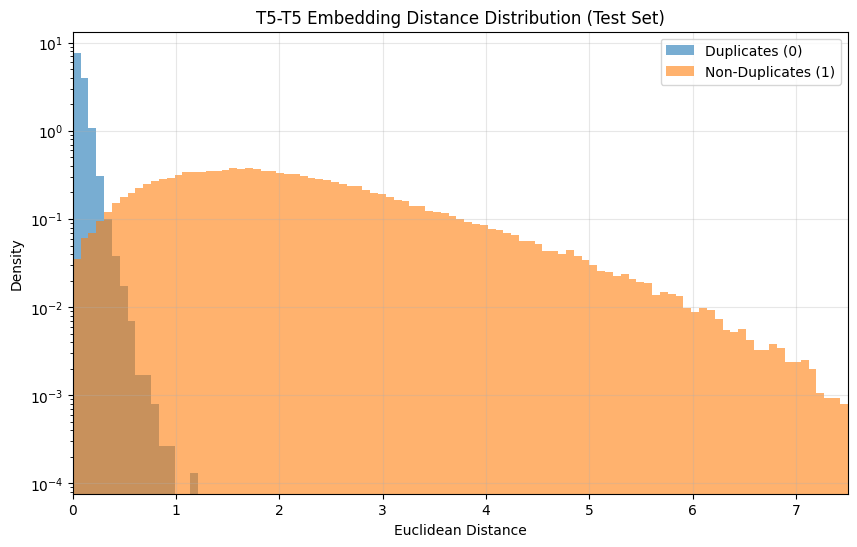

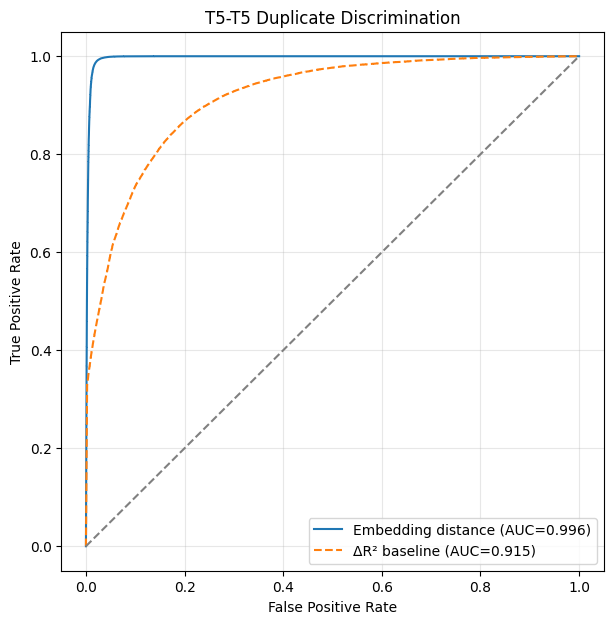

T5-T5 AUC (embedding) = 0.9965
T5-T5 AUC (ΔR²)       = 0.9153


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
embed_t5.eval()

# 1) collect distances and labels
dist_t5_all = []
lbl_t5_all  = []

with torch.no_grad():
    for x_left, x_right, y, _ in test_t5_loader:
        x_left  = x_left.to(device)
        x_right = x_right.to(device)

        e_l = embed_t5(x_left)
        e_r = embed_t5(x_right)
        d   = torch.sqrt(((e_l - e_r) ** 2).sum(dim=1, keepdim=True) + 1e-6)

        dist_t5_all.append(d.cpu().numpy().flatten())
        lbl_t5_all .append(y.numpy().flatten())

dist_t5_all = np.concatenate(dist_t5_all)
lbl_t5_all  = np.concatenate(lbl_t5_all)

print(f"T5-T5 pairs:   {len(dist_t5_all)} distances")
print(f"  Range: min={dist_t5_all.min():.4f}, max={dist_t5_all.max():.4f}")
print(f"  Labels: similar={(lbl_t5_all==0).sum()}, dissimilar={(lbl_t5_all==1).sum()}")

# 2) histogram of distances
plt.figure(figsize=(10,6))
bins = np.linspace(0, 7.5, 100)
plt.hist(dist_t5_all[lbl_t5_all==0], bins=bins, density=True, alpha=0.6, label='Duplicates (0)')
plt.hist(dist_t5_all[lbl_t5_all==1], bins=bins, density=True, alpha=0.6, label='Non-Duplicates (1)')
plt.yscale('log')
plt.xlabel("Euclidean Distance")
plt.ylabel("Density")
plt.title("T5-T5 Embedding Distance Distribution (Test Set)")
plt.legend()
plt.grid(alpha=0.3)
plt.xlim(0,7.5)
plt.show()

# ------------------------------------------------------------------
# ΔR² baseline for the same test split
# ------------------------------------------------------------------
phi_left  = np.arctan2(X_left_test[:, 2], X_left_test[:, 1])
phi_right = np.arctan2(X_right_test[:, 2], X_right_test[:, 1])
eta_left  = X_left_test[:, 0]  * eta_max     # undo η‑normalisation
eta_right = X_right_test[:, 0] * eta_max

dphi = (phi_left - phi_right + np.pi) % (2*np.pi) - np.pi
deta = eta_left - eta_right
dRsq = dphi**2 + deta**2

# 3) ROC curves: embedding vs ΔR² baseline
fpr_t5, tpr_t5, _ = roc_curve(lbl_t5_all, -dist_t5_all, pos_label=0)
fpr_dr, tpr_dr, _ = roc_curve(lbl_t5_all, -dRsq,        pos_label=0)

auc_t5 = auc(fpr_t5, tpr_t5)
auc_dr = auc(fpr_dr,  tpr_dr)

plt.figure(figsize=(7,7))
plt.plot(fpr_t5, tpr_t5, label=f"Embedding distance (AUC={auc_t5:.3f})")
plt.plot(fpr_dr, tpr_dr, '--', label=f"ΔR² baseline (AUC={auc_dr:.3f})")
plt.plot([0,1],[0,1], '--', color='grey')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("T5-T5 Duplicate Discrimination")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

print(f"T5-T5 AUC (embedding) = {auc_t5:.4f}")
print(f"T5-T5 AUC (ΔR²)       = {auc_dr :.4f}")

/ceph/users/atuna/work/gavin_tc_dnn/env/lib64/python3.9/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


pLS-T5 pairs:  200000 distances
  Range: min=0.0082, max=7.8924
  Labels: similar=100000, dissimilar=100000


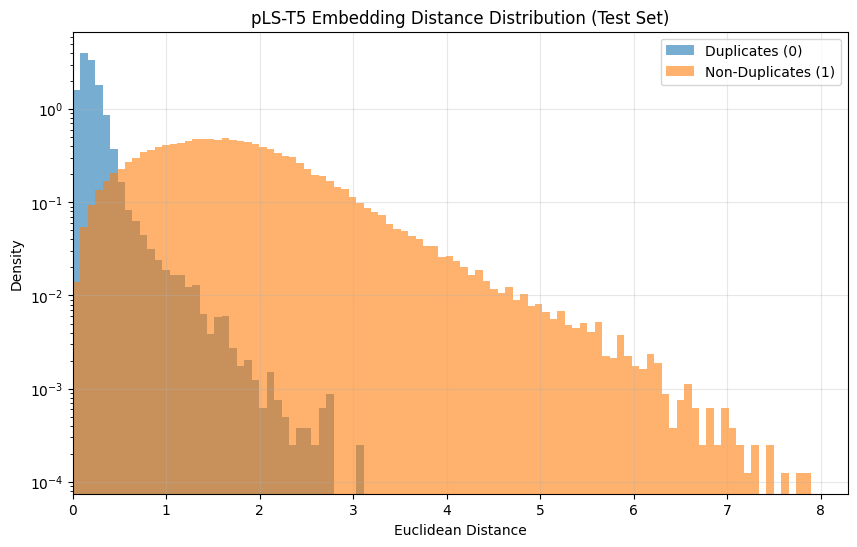

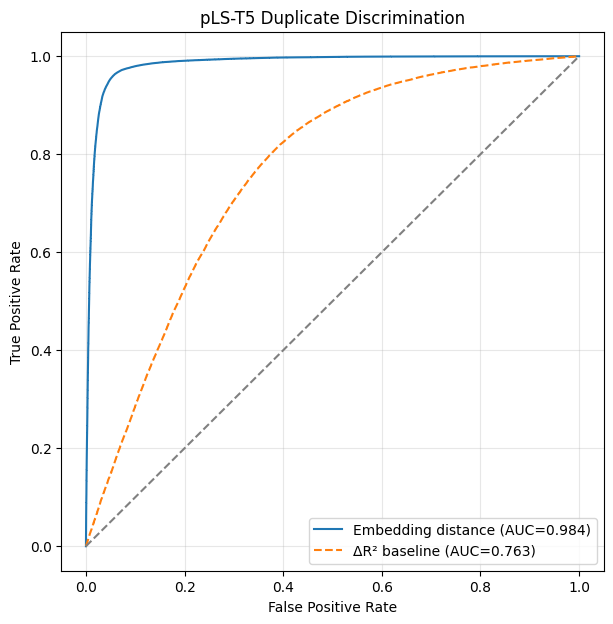

pLS-T5 AUC (embedding) = 0.9844
pLS-T5 AUC (ΔR²)       = 0.7631


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
embed_pls.eval(); embed_t5.eval()

# 1) collect distances and labels ------------------------------------
dist_pls_all = []
lbl_pls_all  = []

with torch.no_grad():
    for pls_feats, t5_feats, y, _ in test_pls_loader:
        pls_feats = pls_feats.to(device)
        t5_feats  = t5_feats.to(device)

        e_p = embed_pls(pls_feats)
        e_t = embed_t5(t5_feats)
        d   = torch.sqrt(((e_p - e_t) ** 2).sum(dim=1, keepdim=True) + 1e-6)

        dist_pls_all.append(d.cpu().numpy().flatten())
        lbl_pls_all .append(y.numpy().flatten())

dist_pls_all = np.concatenate(dist_pls_all)
lbl_pls_all  = np.concatenate(lbl_pls_all)

print(f"pLS-T5 pairs:  {len(dist_pls_all)} distances")
print(f"  Range: min={dist_pls_all.min():.4f}, max={dist_pls_all.max():.4f}")
print(f"  Labels: similar={(lbl_pls_all==0).sum()}, dissimilar={(lbl_pls_all==1).sum()}")

# 2) histogram of distances ------------------------------------------
plt.figure(figsize=(10,6))
bins = np.linspace(0, dist_pls_all.max(), 100)
plt.hist(dist_pls_all[lbl_pls_all==0], bins=bins, density=True, alpha=0.6, label='Duplicates (0)')
plt.hist(dist_pls_all[lbl_pls_all==1], bins=bins, density=True, alpha=0.6, label='Non-Duplicates (1)')
plt.yscale('log')
plt.xlabel("Euclidean Distance")
plt.ylabel("Density")
plt.title("pLS-T5 Embedding Distance Distribution (Test Set)")
plt.legend()
plt.grid(alpha=0.3)
plt.xlim(left=0)
plt.show()

# --------------------------------------------------------------------
# ΔR² baseline for the same pLS-T5 pairs
# --------------------------------------------------------------------
#  — recover φ and η for the raw feature arrays used in the split
phi_left  = np.arctan2(X_pls_test[:, 3],  X_pls_test[:, 2])     # pLS: sinφ, cosφ
phi_right = np.arctan2(X_t5raw_test[:, 2], X_t5raw_test[:, 1])  # T5 : sinφ, cosφ
eta_left  = X_pls_test[:, 0]  * 4.0        # pLS stored η/4
eta_right = X_t5raw_test[:, 0] * eta_max   # T5  stored η/η_max

dphi = (phi_left - phi_right + np.pi) % (2*np.pi) - np.pi
deta = eta_left - eta_right
dRsq = dphi**2 + deta**2

# 3) ROC curves: embedding vs ΔR² baseline ---------------------------
fpr_pls, tpr_pls, _ = roc_curve(lbl_pls_all, -dist_pls_all, pos_label=0)
fpr_dr,  tpr_dr,  _ = roc_curve(lbl_pls_all, -dRsq,         pos_label=0)

auc_pls = auc(fpr_pls, tpr_pls)
auc_dr  = auc(fpr_dr,  tpr_dr)

plt.figure(figsize=(7,7))
plt.plot(fpr_pls, tpr_pls, label=f"Embedding distance (AUC={auc_pls:.3f})")
plt.plot(fpr_dr,  tpr_dr,  '--', label=f"ΔR² baseline (AUC={auc_dr:.3f})")
plt.plot([0,1],[0,1], '--', color='grey')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("pLS-T5 Duplicate Discrimination")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

print(f"pLS-T5 AUC (embedding) = {auc_pls:.4f}")
print(f"pLS-T5 AUC (ΔR²)       = {auc_dr :.4f}")

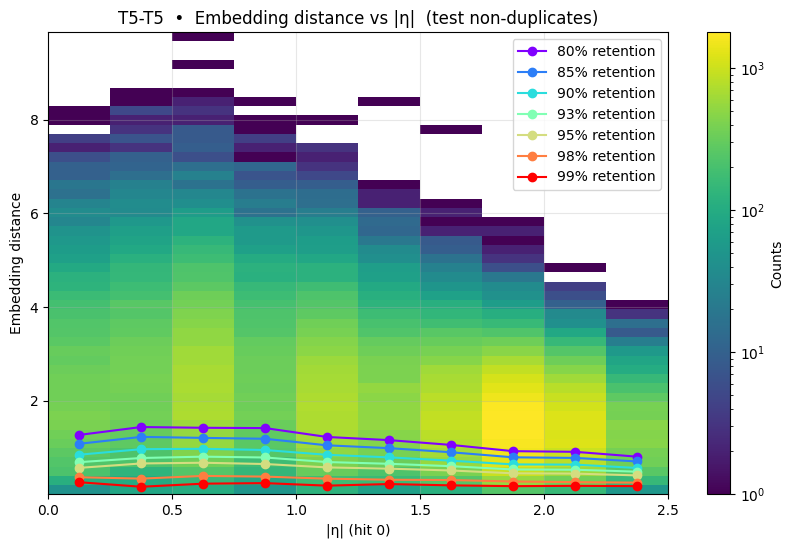

80%-cut:     { 1.2673, 1.4356, 1.4199, 1.4131, 1.2234, 1.1562, 1.0537, 0.9206, 0.9065, 0.8030 }
  80%-dupRej: { 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00 }

85%-cut:     { 1.0776, 1.2248, 1.2040, 1.1853, 1.0448, 0.9850, 0.8967, 0.7891, 0.7762, 0.7006 }
  85%-dupRej: { 99.98, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00 }

90%-cut:     { 0.8446, 0.9629, 0.9710, 0.9451, 0.8419, 0.7879, 0.7175, 0.6376, 0.6331, 0.5615 }
  90%-dupRej: { 99.98, 100.00, 100.00, 100.00, 100.00, 99.97, 99.99, 99.96, 100.00, 100.00 }

93%-cut:     { 0.6856, 0.7745, 0.8031, 0.7852, 0.6882, 0.6508, 0.5994, 0.5293, 0.5239, 0.4825 }
  93%-dupRej: { 99.93, 100.00, 99.98, 100.00, 99.98, 99.97, 99.97, 99.93, 99.99, 99.92 }

95%-cut:     { 0.5637, 0.6580, 0.6733, 0.6460, 0.5734, 0.5467, 0.5077, 0.4476, 0.4415, 0.4029 }
  95%-dupRej: { 99.90, 99.98, 99.97, 100.00, 99.92, 99.83, 99.84, 99.81, 99.94, 99.82 }

98%-cut:     { 0.3639, 0.3343, 0.3921, 0.3769, 0.333

In [12]:
import numpy as np, torch, matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

percentiles   = [80, 85, 90, 93, 95, 98, 99]   # keep this % of non‑duplicates
eta_edges     = np.arange(0.0, 2.75, 0.25)     # |η| binning
dr2_threshold = 1.0e-3                         # ΔR² cut

eta_L  = X_left_test[:, 0] * eta_max
phi_L  = np.arctan2(X_left_test[:, 2], X_left_test[:, 1])
eta_R  = X_right_test[:, 0] * eta_max
phi_R  = np.arctan2(X_right_test[:, 2], X_right_test[:, 1])

abs_eta = np.abs(eta_L)

deta = eta_L - eta_R
dphi = (phi_R - phi_L + np.pi) % (2*np.pi) - np.pi
dR2  = deta**2 + dphi**2                       # ΔR² baseline

embed_t5.eval()
with torch.no_grad():
    L = torch.from_numpy(X_left_test.astype(np.float32)).to(device)
    R = torch.from_numpy(X_right_test.astype(np.float32)).to(device)
    dist = torch.sqrt(((embed_t5(L) - embed_t5(R))**2).sum(dim=1) + 1e-6) \
             .cpu().numpy()

y_test = y_t5_test                              # shorthand

cut_vals   = {p: [] for p in percentiles}
dup_rej    = {p: [] for p in percentiles}
dr2_eff    = []
dr2_rejdup = []

for lo, hi in zip(eta_edges[:-1], eta_edges[1:]):
    nnd = (abs_eta >= lo) & (abs_eta < hi) & (y_test == 1)   # non‑dups
    dup = (abs_eta >= lo) & (abs_eta < hi) & (y_test == 0)   # dups

    # ΔR² metrics
    dr2_eff   .append(np.mean(dR2[nnd] >= dr2_threshold)*100 if np.any(nnd) else np.nan)
    dr2_rejdup.append(np.mean(dR2[dup] <  dr2_threshold)*100 if np.any(dup) else np.nan)

    # embedding‑distance cuts
    for p in percentiles:
        cut = np.percentile(dist[nnd], 100-p) if np.any(nnd) else np.nan
        cut_vals[p].append(cut)
        dup_rej[p].append(np.mean(dist[dup] < cut)*100 if (np.any(dup) and not np.isnan(cut)) else np.nan)

fig, ax = plt.subplots(figsize=(10,6))
h = ax.hist2d(abs_eta[y_test==1], dist[y_test==1],
              bins=[eta_edges, 50], norm=LogNorm())
fig.colorbar(h[3], ax=ax, label='Counts')
ax.set_xlabel('|η| (hit 0)')
ax.set_ylabel('Embedding distance')
ax.set_title('T5-T5  •  Embedding distance vs |η|  (test non‑duplicates)')

mid_eta = eta_edges[:-1] + 0.5*np.diff(eta_edges)
for p, clr in zip(percentiles, plt.cm.rainbow(np.linspace(0,1,len(percentiles)))):
    ax.plot(mid_eta, cut_vals[p], '-o', color=clr, label=f'{p}% retention')
ax.legend(); ax.grid(alpha=0.3); plt.show()

for p in percentiles:
    cuts = ", ".join(f"{v:.4f}" if not np.isnan(v) else "nan" for v in cut_vals[p])
    rejs = ", ".join(f"{v:.2f}"  if not np.isnan(v) else "nan" for v in dup_rej[p])
    print(f"{p}%-cut:     {{ {cuts} }}")
    print(f"  {p}%-dupRej: {{ {rejs} }}")
    print()
eff = ", ".join(f"{v:.2f}" if not np.isnan(v) else "nan" for v in dr2_eff)
rej = ", ".join(f"{v:.2f}" if not np.isnan(v) else "nan" for v in dr2_rejdup)
print(f"dR2-eff  (%): {{ {eff} }}")
print(f"dR2-dupRej (%): {{ {rej} }}")

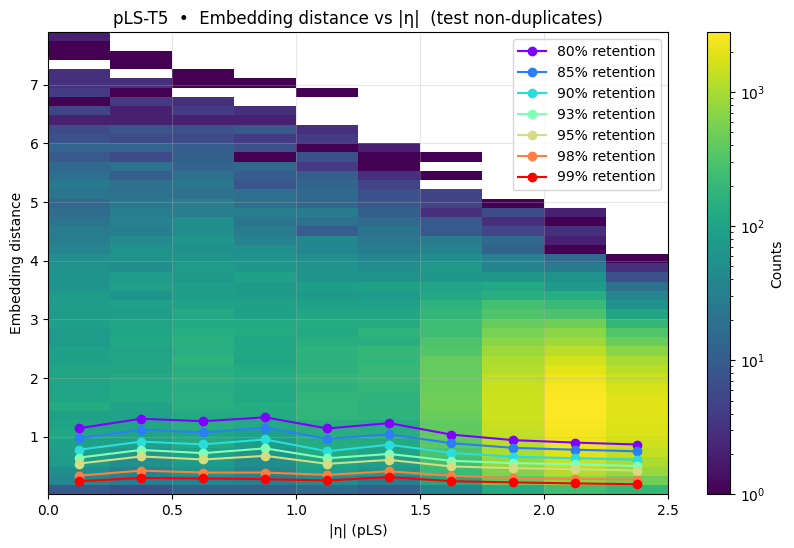

80%-cut:     { 1.1423, 1.3040, 1.2614, 1.3282, 1.1381, 1.2289, 1.0340, 0.9390, 0.8970, 0.8646 }
  80%-dupRej: { 99.36, 99.79, 99.81, 99.54, 99.74, 99.54, 99.33, 99.13, 98.96, 98.59 }

85%-cut:     { 0.9726, 1.1193, 1.0697, 1.1543, 0.9604, 1.0405, 0.8869, 0.8077, 0.7754, 0.7487 }
  85%-dupRej: { 98.91, 99.36, 99.77, 99.44, 99.59, 99.25, 99.02, 98.67, 98.64, 98.13 }

90%-cut:     { 0.7758, 0.9139, 0.8670, 0.9507, 0.7490, 0.8617, 0.7211, 0.6567, 0.6306, 0.6062 }
  90%-dupRej: { 98.02, 99.03, 99.34, 99.34, 98.91, 98.86, 98.53, 97.90, 97.95, 97.20 }

93%-cut:     { 0.6412, 0.7723, 0.7177, 0.7992, 0.6301, 0.7035, 0.5875, 0.5470, 0.5277, 0.4974 }
  93%-dupRej: { 96.42, 98.44, 98.72, 99.14, 98.15, 98.04, 97.71, 96.98, 97.18, 95.94 }

95%-cut:     { 0.5404, 0.6606, 0.6094, 0.6709, 0.5354, 0.6022, 0.4906, 0.4610, 0.4452, 0.4204 }
  95%-dupRej: { 94.25, 97.74, 97.71, 98.63, 96.44, 97.15, 96.60, 95.27, 95.77, 93.77 }

98%-cut:     { 0.3344, 0.4194, 0.3861, 0.3869, 0.3473, 0.4079, 0.3324, 0.2906, 0

In [13]:
import numpy as np, torch, matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

percentiles   = [80, 85, 90, 93, 95, 98, 99]
eta_edges     = np.arange(0.0, 2.75, 0.25)
dr2_threshold = 1.0e-3

eta_L  = X_pls_test[:, 0] * 4.0                     # pLS η was stored as η/4
phi_L  = np.arctan2(X_pls_test[:, 3], X_pls_test[:, 2])
eta_R  = X_t5raw_test[:, 0] * eta_max
phi_R  = np.arctan2(X_t5raw_test[:, 2], X_t5raw_test[:, 1])

abs_eta = np.abs(eta_L)

deta = eta_L - eta_R
dphi = (phi_R - phi_L + np.pi) % (2*np.pi) - np.pi
dR2  = deta**2 + dphi**2

embed_pls.eval(); embed_t5.eval()
with torch.no_grad():
    L = torch.from_numpy(X_pls_test.astype(np.float32)).to(device)
    R = torch.from_numpy(X_t5raw_test.astype(np.float32)).to(device)
    dist = torch.sqrt(((embed_pls(L) - embed_t5(R))**2).sum(dim=1) + 1e-6) \
             .cpu().numpy()

y_test = y_pls_test

cut_vals   = {p: [] for p in percentiles}
dup_rej    = {p: [] for p in percentiles}
dr2_eff    = []
dr2_rejdup = []

for lo, hi in zip(eta_edges[:-1], eta_edges[1:]):
    nnd = (abs_eta >= lo) & (abs_eta < hi) & (y_test == 1)
    dup = (abs_eta >= lo) & (abs_eta < hi) & (y_test == 0)

    dr2_eff   .append(np.mean(dR2[nnd] >= dr2_threshold)*100 if np.any(nnd) else np.nan)
    dr2_rejdup.append(np.mean(dR2[dup] <  dr2_threshold)*100 if np.any(dup) else np.nan)

    for p in percentiles:
        cut = np.percentile(dist[nnd], 100-p) if np.any(nnd) else np.nan
        cut_vals[p].append(cut)
        dup_rej[p].append(np.mean(dist[dup] < cut)*100 if (np.any(dup) and not np.isnan(cut)) else np.nan)

fig, ax = plt.subplots(figsize=(10,6))
h = ax.hist2d(abs_eta[y_test==1], dist[y_test==1],
              bins=[eta_edges, 50], norm=LogNorm())
fig.colorbar(h[3], ax=ax, label='Counts')
ax.set_xlabel('|η| (pLS)')
ax.set_ylabel('Embedding distance')
ax.set_title('pLS-T5  •  Embedding distance vs |η|  (test non-duplicates)')

mid_eta = eta_edges[:-1] + 0.5*np.diff(eta_edges)
for p, clr in zip(percentiles, plt.cm.rainbow(np.linspace(0,1,len(percentiles)))):
    ax.plot(mid_eta, cut_vals[p], '-o', color=clr, label=f'{p}% retention')
ax.legend(); ax.grid(alpha=0.3); plt.show()

for p in percentiles:
    cuts = ", ".join(f"{v:.4f}" if not np.isnan(v) else "nan" for v in cut_vals[p])
    rejs = ", ".join(f"{v:.2f}"  if not np.isnan(v) else "nan" for v in dup_rej[p])
    print(f"{p}%-cut:     {{ {cuts} }}")
    print(f"  {p}%-dupRej: {{ {rejs} }}")
    print()
eff = ", ".join(f"{v:.2f}" if not np.isnan(v) else "nan" for v in dr2_eff)
rej = ", ".join(f"{v:.2f}" if not np.isnan(v) else "nan" for v in dr2_rejdup)
print(f"dR2-eff  (%): {{ {eff} }}")
print(f"dR2-dupRej (%): {{ {rej} }}")

In [14]:
def print_formatted_weights_biases(weights, biases, layer_name):
    # Print biases
    print(f"HOST_DEVICE_CONSTANT float bias_{layer_name}[{len(biases)}] = {{")
    print(", ".join(f"{b:.7f}f" for b in biases) + " };")
    print()

    # Print weights
    print(f"HOST_DEVICE_CONSTANT const float wgtT_{layer_name}[{len(weights[0])}][{len(weights)}] = {{")
    for row in weights.T:
        formatted_row = ", ".join(f"{w:.7f}f" for w in row)
        print(f"{{ {formatted_row} }},")
    print("};")
    print()

def print_model_weights_biases(model):
    # Make sure the model is in evaluation mode
    model.eval()

    # Iterate through all named modules in the model
    for name, module in model.named_modules():
        # Check if the module is a linear layer
        if isinstance(module, nn.Linear):
            # Get weights and biases
            weights = module.weight.data.cpu().numpy()
            biases = module.bias.data.cpu().numpy()

            # Print formatted weights and biases
            print_formatted_weights_biases(weights, biases, name.replace('.', '_'))

In [15]:
print_model_weights_biases(embed_pls)

HOST_DEVICE_CONSTANT float bias_fc1[32] = {
-0.1559781f, 0.1747788f, -0.0085052f, 0.0093877f, 0.0401038f, -0.0599571f, -0.0289430f, 0.4930527f, 0.1899822f, -0.2494508f, 0.0318529f, -0.4498090f, -0.2991863f, -0.2265607f, 0.0710623f, -0.1398940f, 0.2315173f, -0.7628233f, 0.0933388f, -0.1744881f, -0.0109088f, -0.2737665f, 0.7274613f, -0.2143985f, -0.1654108f, -0.6567009f, 0.9642400f, 0.2734349f, 0.4771416f, -0.1140133f, 0.5628085f, -1.1416121f };

HOST_DEVICE_CONSTANT const float wgtT_fc1[10][32] = {
{ 0.0509987f, -1.2374693f, -0.0503314f, -0.2821673f, -0.8624601f, -3.0510564f, -0.2178211f, 0.2029785f, -0.4193125f, 0.5254869f, 0.2450780f, 0.0911098f, 2.7126281f, -1.4028199f, 0.2873713f, 1.7941598f, 1.2315580f, -0.3141005f, 0.3108614f, -0.0922423f, 0.0543097f, 0.3039565f, 1.1257803f, -0.4443436f, -0.1489394f, 0.1382348f, -0.0602673f, -0.1273460f, 0.3377123f, -0.1947415f, -0.3022571f, -0.2634747f },
{ -0.0056649f, 0.4369218f, -0.3721994f, -0.2577025f, -1.7469517f, -0.0706760f, -0.2821010f, 

In [16]:
print_model_weights_biases(embed_t5)

HOST_DEVICE_CONSTANT float bias_fc1[32] = {
-0.0070950f, 0.0483153f, -0.1714809f, -0.0619338f, 0.5003749f, 0.4936592f, 0.4366209f, 0.2270864f, 0.1796190f, -0.2237834f, 0.0484209f, 0.3805575f, 0.3089804f, 0.2396508f, 0.3820187f, 0.1624822f, 0.0964319f, 0.8690858f, 0.4302914f, 0.1721707f, 0.4528022f, 0.1742375f, 0.3776777f, 0.4193507f, -0.2186293f, 0.2223508f, 0.3094296f, 0.3427083f, -0.1525913f, 0.1829060f, 0.2171213f, 0.1247661f };

HOST_DEVICE_CONSTANT const float wgtT_fc1[30][32] = {
{ 0.0017357f, 0.0063071f, 0.0074649f, 0.0172222f, 0.0022545f, 0.0055353f, -0.0001761f, -0.0096569f, -0.0025082f, -0.0066309f, -0.0080406f, 0.0037136f, -0.0068628f, 0.0044322f, 0.0017170f, 0.0130056f, 0.0049672f, 0.0002304f, -0.0040735f, -0.0012713f, -0.0061464f, 0.0086481f, 0.0106603f, 0.0015241f, -0.0099483f, 0.0109742f, 0.0032562f, -0.0007806f, -0.0004910f, 0.0000930f, 0.0058743f, -0.0100097f },
{ 0.1515380f, -0.1550910f, -0.1246142f, -0.0465489f, -0.0679364f, -0.0785299f, 0.0943163f, 0.0842940f, -0.08